# Tutoriel : Réseau de neurones avec PyTorch

In [1]:
# Import 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import helper

import matplotlib.pyplot as plt

Ce tutoriel consiste à construire un réseau de neurones pour résoudre un problème (auparavant) difficile de classification de vêtements à partir d'images. Le dataset Fashion-MNIST est composé d'images de vêtements en niveaux de gris. Chaque image du dataset est de taille 28x28 pixels. 

<img src='img/fashion-mnist-sprite.png'  width=500px>

L'objectif est de construire un réseau de neurones qui prend en entrée une de ses images et prédit quel type de vêtements est dans l'image passée en entrée (parmi 10 classes possibles de vêtements).

## Dataset Fashion-MNIST

Tout d'abord, le dataset Fashion-MNIST est récupéré à partir du package `torchvision`.Le code ci-dessous charge le dataset, puis crée les dataset d'entrainement et de test.

In [2]:
from torchvision import datasets, transforms

# Une transformation est definie pour normaliser les donness
# La tranasformation est appliqué après le chargement des images, avant de les envoyer au NN
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5]) 
                             ])

# Chargement des donnees d'entrainement
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Chargement des donnees de test
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

0.0%

100.0%

Extracting F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


111.0%

Extracting F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw


100.0%

Extracting F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to F_MNIST_data/FashionMNIST/raw


159.1%/Users/laetitiamatignon/anaconda3/envs/deeprlTP/lib/python3.6/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629444482/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to F_MNIST_data/FashionMNIST/raw
Processing...
Done!


Les données d'entrainement sont chargées dans `trainloader` et un itérateur est disponible avec `iter(trainloader)`. Pour boucler sur les données du dataset:

```python
for image, label in trainloader:
    ## do things with images and labels
```

`trainloader` est créé avec une taille de batch de 64, i.e. que **64 images sont récupérées à chaque itération**. Ces 64 images, ou *batch*, seront envoyées en entrée du réseau. `shuffle=True` permet de mélanger le dataset à chaque appel du `dataloader`.

Ci-dessous, on récupère un batch dans `images` qui est donc un tenseur de taille  `(64, 1, 28, 28)`, soit 64 images par batch, 1 color channel, et la taille des images 28x28.

> **Exercice**: afficher ci-dessous le type et la taille d'un batch


In [3]:
#recuperation d'un batch
dataiter = iter(trainloader)
images, labels = dataiter.next()

# TODO

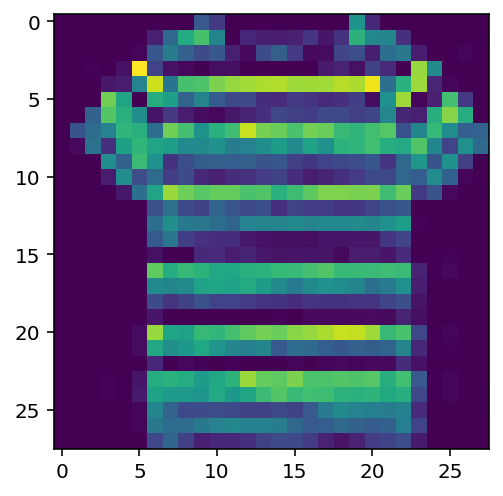

In [4]:
#affichage de la premiere image du batch
plt.imshow(images[0].numpy().squeeze());
#The squeeze() function is used to remove single- dimensional entries from the shape of an array.

## Rappel réseau de neurones

Un réseau de neurones est composé d'unités individuelles d'approximation non linéaire, ou neurones. Le réseau de neurones le plus simple est le perceptron mono-couches. Il prend des données en entrées (par ex. 3 entrées ci-dessous), puis réalise une combinaison linéaire : chaque entrée est pondérée par un poids, puis on fait la somme pondérée des entrées (plus le biais). Cette combinaison linéaire est ensuite passée à une fonction d'activation pour calculer la sortie. Les poids $w_i$ sont les paramètres du modèle, mis à jour lors de la remontée de gradient (*backward pass*) pour améliorer la prédiction du réseau.

<img src="img/perceptronmono.png" width=600px>

D'un point de vue mathématique, le perceptron mono-couche ci-dessus calcule (prédiction - *forward pass*):

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + w_3 x_3 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

Les fonctions d'activation introduisent la non-linéarité dans le réseau de neurones. Différentes fonctions d'activation peuvent être choisies:

<img src="img/activation.png" width=700px>

* L'une des premières fonction d'activation a été la fonction *sigmoïd* aussi connue sous le nom de *fonction logistique*. Elle présente cependant quelques inconvénients, en particulier, le gradient (dérivée) à ses extrémités (0 ou 1) est nul. A cause de cette limitation, le modèle peut souffrir de ce que l'on appelle le **vanishing gradient**, qui signifie que le gradient de la fonction diminue progressivement (peut même devenir nul) et l'apprentissage devient moins efficace car les paramètres ne sont plus mis à jour correctement. 
* Une autre fonction d'activation qui marche presque toujours mieux que la fonction logistique est la fonction *tangente hyperbolique*, dont les valeurs de sortie sont centrée en 0 (contrairement à sigmoid). Mais elle présente aussi le problème du vanishing gradient.  
* La fonction d'activation la plus utilisée de nos jours est la **ReLU - Rectified Linear Unit -** qui est une fonction linéaire par morceaux. Son avantage réside sur le fait qu'elle remplace toute valeur d'entrée négative par 0 et toute valeur positive par elle même (ReLU réalise la fonciton  $max(0,x)$). De plus, son gradient devient nul pour les valeurs négatives et vaut 1 pour les valeurs positives. Cette propriété est très intéressante dans la phase d'apprentissage car elle permet d'éviter et de corriger le problème du vanishing gradient. 


Dans un perceptron multi-couches, ou modèle *feed-forward*, plusieurs couches de neurones sont accumulées, où chaque neurone d'une couche est connecté à chaque neurone de la couche suivante. Ci-dessous, un perceptron multi-couches avec 4 entrées et 3 sorties.

<img src="img/mlp.png" width=600px>

## Exemple: Construction d'un réseau de neurones avec PyTorch

Pour construire un réseau de neurones, nous utilisons le module [torch.nn](https://pytorch.org/docs/stable/nn.html) et héritons de la classe `torch.nn.Module`.

* Dans le constructeur `init`, les paramètres du modèle sont définis. Ces paramètres sont les poids de chaque couche, i.e. des tenseurs sur lesquels une remontée de gradient devra être réalisée lors de l'apprentissage du réseau. Pour cela, on peut utiliser les *layers* de PyTorch. Ainsi, chaque couche du réseau est définie séparément. Pour un réseau *feed-forward* où chaque couche réalise une combinaison linéaire, on utilise le *layer* `nn.Linear(nbx,nby)` où `nbx` est le nombre d'entrées et `nby` le nombre de sorties de la couche. 

* La méthode `forward(x)` réalise la prédiction (*forward pass*) du réseau pour une entrée `x`. Il faut donc réaliser les prédictions de chaque couche du modèle, et les passer aux fonctions d'activation. Pour les fonctions d'activation, le module `torch.nn.functional`  est couramment importé sous le nom `F`. Pour une activation ReLU par exemple, `F.relu(x)` calcule l'activation ReLU pour le tenseur `x`.


Le perceptron mono-couche donné en exemple précédemment est modélisé ci-dessous en PyTorch:

In [5]:
class PerceptronMonoCouche(nn.Module):
    def __init__(self):
        super().__init__()
        
        #bonne pratique: nommer vos couches selon leur type, par exemple `fc` pour une couche fully-connected.
        self.fc1 = nn.Linear(3, 1)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''

        x = self.fc1(x) #prédiction de la couche linéaire fc1
        x = F.relu(x) # application de la fonction d'activation ReLU
        return x
    

On instancie ensuite une variable `model`de type `PerceptronMonoCouche`, et on peut afficher les poids et biais.

In [6]:
model = PerceptronMonoCouche()
# affichage des poids et biais de la couche fc1 du modèle (automatiquement initialisé)
print("poids init auto: ",model.fc1.weight)
print("biais init auto:" ,model.fc1.bias)

# Init des biais à 0
model.fc1.bias.data.fill_(0)
print("biais init 0:" ,model.fc1.bias)

# Init des poids selon random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)
print("poids init random: ",model.fc1.weight)

poids init auto:  Parameter containing:
tensor([[ 0.5168,  0.2285, -0.0417]], requires_grad=True)
biais init auto: Parameter containing:
tensor([-0.1621], requires_grad=True)
biais init 0: Parameter containing:
tensor([0.], requires_grad=True)
poids init random:  Parameter containing:
tensor([[-0.0032,  0.0040,  0.0137]], requires_grad=True)


#### Données d'entrée du réseau (batch)

On peut calculer la prédiction du modèle (*forward pass*) pour une **unique** donnée d'entrée `x` qui est un tenseur 1D:

In [7]:
x = torch.rand(3)
print("input",x, x.size())
out = model(x)
print("prediction du modele PerceptronMonoCouche: ",out)

input tensor([0.5802, 0.2034, 0.6309]) torch.Size([3])
prediction du modele PerceptronMonoCouche:  tensor([0.0076], grad_fn=<ReluBackward0>)


On peut aussi passer au réseau les données d'un batch, sous forme d'un **tenseur 2D** de taille (taille du batch, taille de l'entrée). Le réseau réalisera les prédictions pour chaque élément du batch:

In [8]:
#batch de taille 10
xbatch = torch.rand(10,3)
print("input batch",xbatch,xbatch.size())
out = model(xbatch)
print("prediction du modele PerceptronMonoCouche pour le batch: ",out)

input batch tensor([[0.1788, 0.0696, 0.7768],
        [0.8025, 0.2738, 0.7749],
        [0.1583, 0.9450, 0.0882],
        [0.3875, 0.2027, 0.9338],
        [0.0667, 0.1550, 0.1618],
        [0.6405, 0.9410, 0.7455],
        [0.0412, 0.4330, 0.6001],
        [0.9408, 0.6775, 0.3296],
        [0.2197, 0.7348, 0.8378],
        [0.2211, 0.9318, 0.8706]]) torch.Size([10, 3])
prediction du modele PerceptronMonoCouche pour le batch:  tensor([[0.0104],
        [0.0092],
        [0.0045],
        [0.0124],
        [0.0026],
        [0.0119],
        [0.0098],
        [0.0042],
        [0.0137],
        [0.0150]], grad_fn=<ReluBackward0>)


## Exercice: Construction du réseau de neurones pour Fashion-MNIST

Pour concevoir le réseau *feed forward* pour traiter les données du dataset MNIST, il faut :
* connaitre la taille des données d'entrées: les images MNIST sont de taille `28x28` pixels.  Pour passer une image en entrée du réseau, l'image 2D doit être convertit en un tenseur 1D (applatit , *flattened*), ici de taille $28 x 28 = 784$.  Les batchs récupérés sont de taille `64`,  soit un tenseur `(64,1,28,28)`pour 64 images par batch, 1 color channel, et la taille des images 28x28. Dans le cas de batch d'images, des tenseurs 2D peuvent être passés au réseau $(64,784)$.

* connaitre la taille de la sortie: le problème est ici un problème de classification en 10 classes (10 types de vêtements). La taille de la sortie du réseau sera donc `10`, 1 sortie par classe. 

* décider des fonctions d'activation à appliquer: pour les couches cachées, la fonction d'activation ReLU est choisie.

* pour la couche de sortie,  on souhaite que la `i`-ème sortie calcule la probabilité que l'image passée  en entrée soit de la classe `i`. Pour convertir la sortie du réseau en distribution de probabilité, la fonction d'activation [**softmax**](https://en.wikipedia.org/wiki/Softmax_function) peut être utilisée car elle permet de *formater* les 10 valeurs de sortie pour qu'elles soient entre 0 et 1 avec une somme égale à 1. La [log-probability](https://en.wikipedia.org/wiki/Log_probability), qui est une fonction qui calcule le logarithme de la fonction softmax, est à préférer car elle apporte différents avantages: les calculs sont souvent plus rapide et plus précis (cf. illustration [ici](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)). Pour récupérer les probabilités à partir de la log-probabilité, il suffit de prendre l'exponentiel (`torch.exp`), en effet:
$$ \large{e^{\ln{x}} = x }$$




In [9]:
#recuperation d'un batch
dataiter = iter(trainloader)
images, labels = dataiter.next()
print("taille du batch initial: ",images.size())

#aplatissement des images du batch en 1D
images.resize_(images.shape[0], 784) 
print("taille du batch final: ",images.size())

print(images[0].size())

taille du batch initial:  torch.Size([64, 1, 28, 28])
taille du batch final:  torch.Size([64, 784])
torch.Size([784])


Nous proposons de construire pour débuter le réseau suivant (avec `log_softmax` en sortie et pas `softmax`):

<img src="img/mlp_mnist2.png" width=600px>





> **Exercice:** Construisez ce réseau. Instanciez le dans une variable `model`. 


In [4]:
# TODO



Network(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [ ]:
print(model)

## Forward pass

On va afficher les prédictions du modèle (probabilité de chaque classe) en passant une unique image au réseau:

> **Exercice:** Compléter le code ci-dessous

In [10]:
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 784) 

# FRécupération de la première image du batch
img_idx = 0 
img = images[img_idx]

# TODO: forward pass du modele
output = ...



# Calcul des proba
probs = torch.exp(output)

# Visualisation des prédictions
helper.view_classify(img.view(1, 28, 28), probs, version='Fashion') 

TypeError: exp(): argument 'input' (position 1) must be Tensor, not ellipsis

> **Exercice:** Que pouvez-vous en conclure ?



## Exercice: Entrainement du NN

Pour entrainer le réseau de neurones, nous devons :
*  définir la fonction de perte à utiliser, dans notre cas, la fonction de perte [**Logarithme Négatif**](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) est adapté à notre problème de classification et à la sortie log-softmax du réseau.

* définir l'optimiseur à utiliser, qui se chargera de mettre à jour les paramètres/poids du réseau. Dans notre cas, nous pouvons utiliser la descente de gradient stochastique (SGD) avec `torch.optim.SGD`.

In [125]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

### Entrainement pas à pas

Nous allons tout d'abord considérer *une seule itération d'apprentissage*, i.e. une seule mise à jour des paramètres en utilisant un mini-batch de 64 images. Les 4 étapes pour la mise à jour des paramètres sont les suivantes:

* *forward pass*: calcul des prédictions du modèle 
* calcul de la *loss*
* *backward pass*: calcul du gradient 
* mise à jour des paramètres (poids du réseau)

> **Exercice:** Implémentez ci-dessous une itération de descente de gradient sur un mini-batch.

In [11]:
print('Poids initiaux - ', model.fc1.weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)


#TODO



##Apres une backward pass
print('Gradient -', model.fc1.weight.grad)
print('Poids mis à jour - ', model.fc1.weight)

Poids initiaux -  Parameter containing:
tensor([[-0.0032,  0.0040,  0.0137]], requires_grad=True)
Gradient - None
Poids mis à jour -  Parameter containing:
tensor([[-0.0032,  0.0040,  0.0137]], requires_grad=True)


### Entrainement itératif sur plusieurs *epochs*


> **Exercice:** Implémentez ci-dessous l'apprentissage complet du réseau de neurones sur plusieurs **epochs**. Vous afficherez toutes les 40 itérations:
* le numéro de l'epoch
* la perte d'entrainement,qui est la somme des pertes sur ces 40 itérations divisé par 40


In [127]:
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [12]:
# exemple pour un affichage dans une boucle
repets = 5
for i in range(repets):
    print("repet: {}/{}.. ".format(i+1, repets),
         "affiche:: {:.3f}.. ".format(i+1/repets))
    

repet: 1/5..  affiche:: 0.200.. 
repet: 2/5..  affiche:: 1.200.. 
repet: 3/5..  affiche:: 2.200.. 
repet: 4/5..  affiche:: 3.200.. 
repet: 5/5..  affiche:: 4.200.. 


In [9]:
# TODO

            
 

### Visualisation des prédictions sur une image

> Exercice: Compléter le code ci-dessous


In [13]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)

# TODO



# Calcul des proba
probs = torch.exp(output)

# Visualisation des prédictions
helper.view_classify(img.resize_(1, 28, 28), probs, version='Fashion')

TypeError: exp(): argument 'input' (position 1) must be Tensor, not ellipsis

## Test du réseau et calcul de la précision (*accuracy*)

Maintenant que le réseau a été entrainé, nous pouvons tester ses performances. Pour cela, nous pouvons utiliser la perte (*loss*) et/ou la précision (*accuracy*) du réseau, qui correspond au pourcentage de prédictions justes sur l'ensemble des prédictions réalisées.

* La précision sur les données d'entrainement permet d'évaluer le sous-apprentissage (*underfit*). Si la précision sur les données d'entrainement est faible, le modèle échoue à apprendre la fonction de prédiction. Dans ce cas, les solutions peuvent être de modifier l'architecture du réseau (par ex. pour un réseau plus grand) ou d'entrainer le réseau plus longtemps. 

* La précision sur les données de test permet de vérifier si le réseau est capable de **généraliser**, i.e. de réaliser des prédictions sur des données qu'il n'a jamais vu. Si la précision sur les données de test est faible (et que la précision sur les données d'entrainement est élevée), le réseau éhcoue à généraliser (sur-apprentissage, *overfit*).  Dans ce cas, les solutions peuvent être de d'utiliser plus de données d'entrainement, de diminuer le nombre de paramètres, ou de faire de la [**régularisation**](https://medium.com/yottabytes/a-quick-guide-on-basic-regularization-methods-for-neural-networks-e10feb101328), par ex. le *dropout*.



> **Exercice**: Calculer et afficher ci-dessous la précision de votre réseau sur les données d'entrainement et sur les données de test.

In [14]:
# TODO

# affichage des précision (en pourcentage)
print('Précision du réseau sur les %d images d entrainement: %d %%' % (total_train,
    accuracy_train))
print('Précision du réseau sur les %d images de test: %d %%' % (total_test,
    accuracy_test))




NameError: name 'total_train' is not defined

## Sauvegarde d'un réseau

Il est utile de pouvoir sauvegarder un réseau entrainé pour le recharger plus tard (afin de plus l'entrainer, ou de l'utiliser pour faire des prédictions).  Les paramètres d'un réseau PyTorch sont dans `state_dict`. Cette variable contient les poids et biais de chaque couche.


In [15]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 PerceptronMonoCouche(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias'])


Le plus simple pour sauvegarder un réseau est de sauvegarder `state_dict` avec `torch.save`, par exemple dans un fichier `checkpoint.pth`.

In [16]:
torch.save(model.state_dict(), 'checkpoint.pth')

On peut ensuite charger  `state_dict` avec `torch.load`.

In [17]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias'])


Cette méthode fonctionne si l'architecture du modèle dans lequel on chargera les poids et biais est identique à celle du réseau sauvegardé. 

In [21]:
model = PerceptronMonoCouche()
model.load_state_dict(state_dict)
print(model)

PerceptronMonoCouche(
  (fc1): Linear(in_features=3, out_features=1, bias=True)
)



## Compte-rendu

Vous pouvez maintenant modifier des éléments pour améliorer la précision de votre réseau si besoin !

> Exercice: Préciser ci-dessous les difficultés rencontrés pendant ce TP, les précisions d'entrainement et de test que vous avez obtenu avec le réseau proposé, et les modifications que vous avez peut être testées pour améliorer l'apprentissage.